In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

STEP 1: LOADING AND EXPLORING DATA
Loaded 1000 matches

DATASET OVERVIEW:
Shape: (1000, 16)
Columns: ['team1_strength', 'team2_strength', 'strength_difference', 'home_advantage', 'competition_level', 'team1_goals_per_game', 'team2_goals_per_game', 'team1_goals_against_per_game', 'team2_goals_against_per_game', 'team1_shots_per_game', 'team2_shots_per_game', 'team1_shot_accuracy', 'team2_shot_accuracy', 'team1_possession', 'team2_possession', 'outcome']

TARGET VARIABLE (what we're predicting):
outcome
0    682
1    206
2    112
Name: count, dtype: int64
0 = Real Madrid wins, 1 = Draw, 2 = Kairat wins

DATA TYPES:
team1_strength                  float64
team2_strength                  float64
strength_difference             float64
home_advantage                    int64
competition_level                 int64
team1_goals_per_game            float64
team2_goals_per_game            float64
team1_goals_against_per_game    float64
team2_goals_against_per_game    float64
team1_shots_per_gam

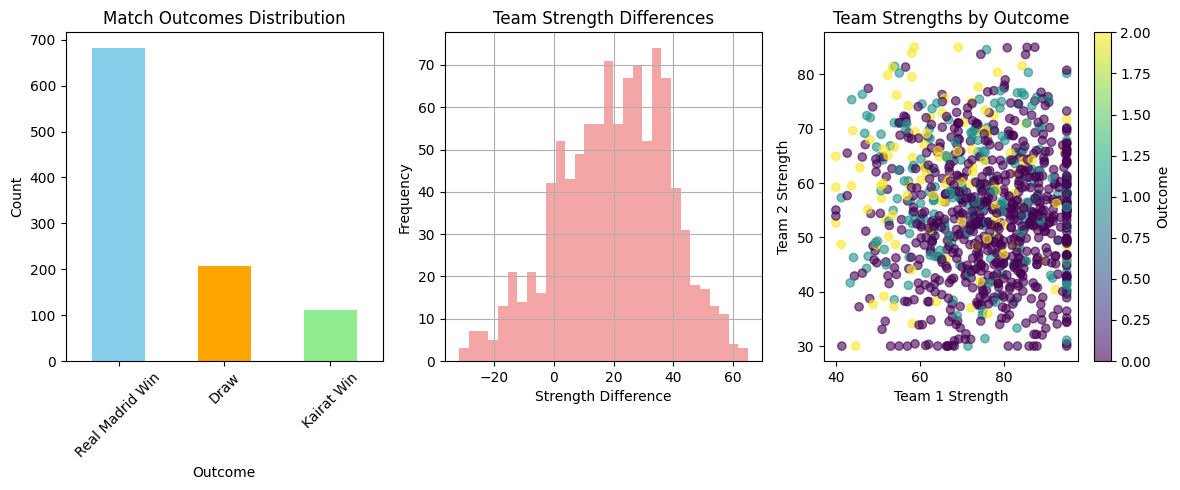

In [4]:
print("STEP 1: LOADING AND EXPLORING DATA")
print("=" * 50)

try:
    df = pd.read_csv('football_training_dataset.csv')
    print(f"Loaded {len(df)} matches")
except:
    exit()

print(f"\nDATASET OVERVIEW:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

print(f"\nTARGET VARIABLE (what we're predicting):")
print(df['outcome'].value_counts())
print("0 = Real Madrid wins, 1 = Draw, 2 = Kairat wins")

print(f"\nDATA TYPES:")
print(df.dtypes)

print(f"\nMISSING VALUES:")
print(df.isnull().sum())

print(f"\nBASIC STATISTICS:")
print(df.describe().round(2))

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
df['outcome'].value_counts().plot(kind='bar', color=['skyblue', 'orange', 'lightgreen'])
plt.title('Match Outcomes Distribution')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['Real Madrid Win', 'Draw', 'Kairat Win'], rotation=45)

plt.subplot(1, 3, 2)
df['strength_difference'].hist(bins=30, color='lightcoral', alpha=0.7)
plt.title('Team Strength Differences')
plt.xlabel('Strength Difference')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.scatter(df['team1_strength'], df['team2_strength'],
           c=df['outcome'], alpha=0.6, cmap='viridis')
plt.xlabel('Team 1 Strength')
plt.ylabel('Team 2 Strength')
plt.title('Team Strengths by Outcome')
plt.colorbar(label='Outcome')

plt.tight_layout()
plt.show()

In [7]:
print("\nSTEP 2: DATA CLEANING AND PREPARATION")
print("=" * 50)

print("WHAT WE'RE DOING:")
print("1. Checking for missing values")
print("2. Removing outliers if needed")
print("3. Creating additional features")
print("4. Selecting final features for modeling")

print(f"\nMissing values before cleaning: {df.isnull().sum().sum()}")
df = df.fillna(df.mean())

# 2. Remove extreme outliers (beyond 3 standard deviations)

numeric_columns = df.select_dtypes(include=[np.number]).columns

before_shape = df.shape[0]
for column in numeric_columns:
    if column != 'outcome':  # Don't remove based on target variable
        mean = df[column].mean()
        std = df[column].std()
        df = df[(df[column] >= mean - 3*std) & (df[column] <= mean + 3*std)]

after_shape = df.shape[0]
print(f"Removed {before_shape - after_shape} outliers ({((before_shape-after_shape)/before_shape)*100:.1f}%)")

print(f"\nCreating additional features...")
df['goal_difference'] = df['team1_goals_per_game'] - df['team2_goals_per_game']
df['defensive_difference'] = df['team2_goals_against_per_game'] - df['team1_goals_against_per_game']

# Efficiency ratios
# WHY: A team that scores more goals per shot is more efficient
df['team1_efficiency'] = df['team1_goals_per_game'] / (df['team1_shots_per_game'] + 0.1)
df['team2_efficiency'] = df['team2_goals_per_game'] / (df['team2_shots_per_game'] + 0.1)

# Shot accuracy difference
# WHY: Better shooting accuracy often leads to more goals
df['shot_accuracy_difference'] = df['team1_shot_accuracy'] - df['team2_shot_accuracy']

# Overall team quality score
# WHY: Combining multiple metrics gives a better overall team assessment
df['team1_quality'] = (df['team1_strength'] + df['team1_shot_accuracy'] + df['team1_possession']) / 3
df['team2_quality'] = (df['team2_strength'] + df['team2_shot_accuracy'] + df['team2_possession']) / 3
df['quality_difference'] = df['team1_quality'] - df['team2_quality']

feature_columns = [
    # Original features
    'strength_difference', 'home_advantage', 'competition_level',
    'team1_goals_per_game', 'team2_goals_per_game',
    'team1_goals_against_per_game', 'team2_goals_against_per_game',
    'team1_shots_per_game', 'team2_shots_per_game',
    'team1_shot_accuracy', 'team2_shot_accuracy',
    'team1_possession', 'team2_possession',
    # New features
    'goal_difference', 'defensive_difference',
    'team1_efficiency', 'team2_efficiency',
    'shot_accuracy_difference', 'quality_difference'
]

print(f"\nFinal feature set: {len(feature_columns)} features")


STEP 2: DATA CLEANING AND PREPARATION
WHAT WE'RE DOING:
1. Checking for missing values
2. Removing outliers if needed
3. Creating additional features
4. Selecting final features for modeling

Missing values before cleaning: 0
Removed 3 outliers (0.3%)

Creating additional features...

Final feature set: 19 features



STEP 3: FEATURE ANALYSIS
ANALYZING FEATURE CORRELATIONS...


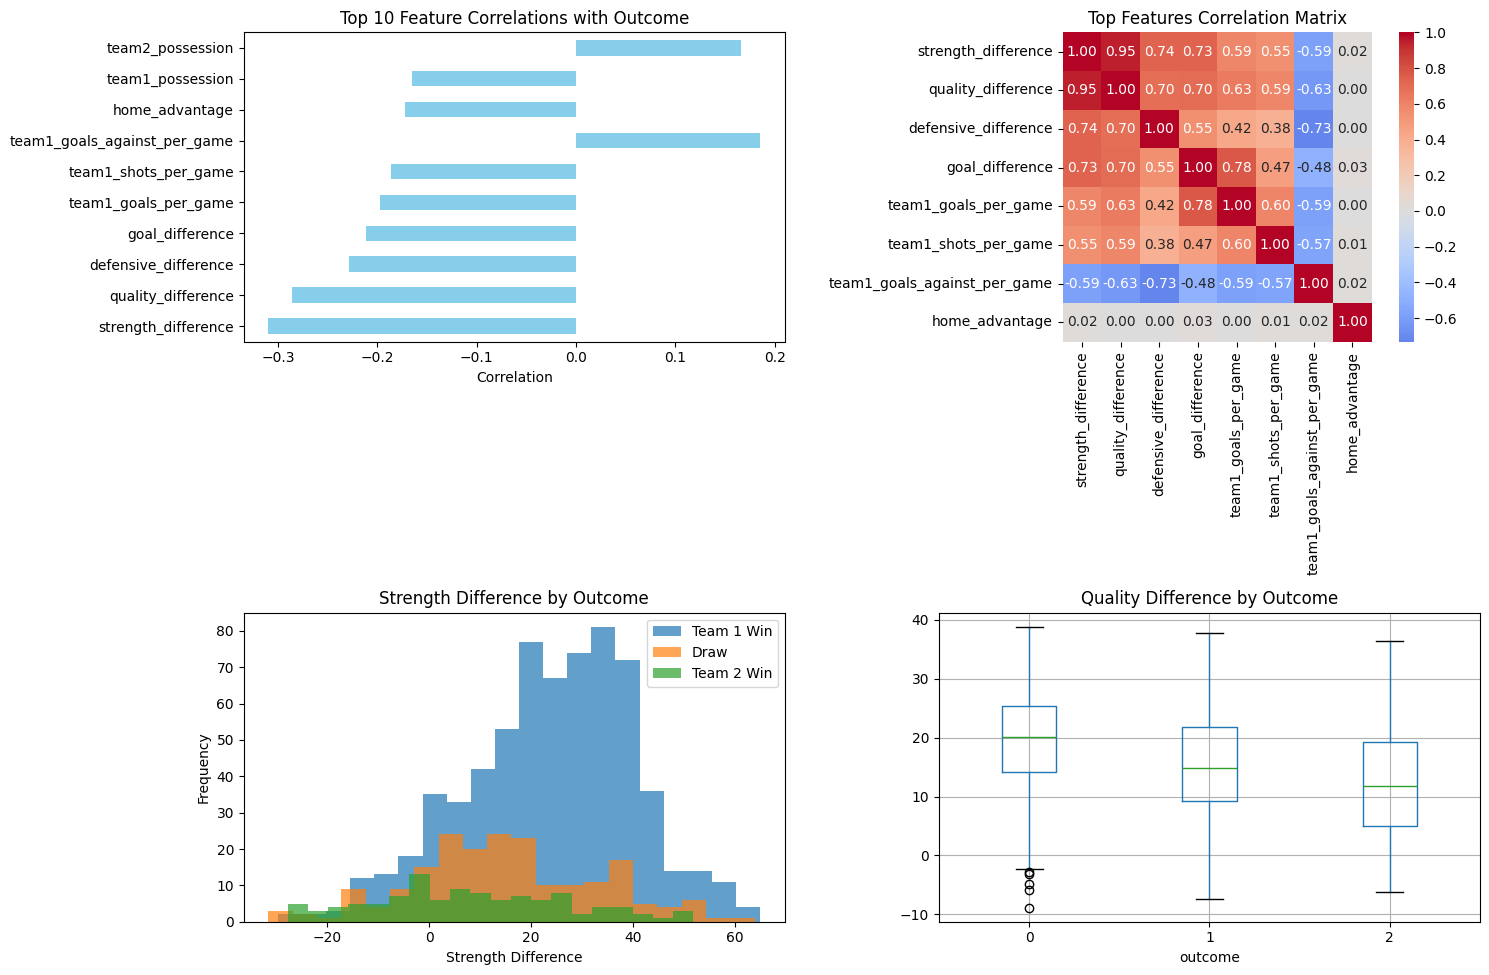


KEY INSIGHTS:
Most important features (by correlation):
1. strength_difference: -0.310
2. quality_difference: -0.286
3. defensive_difference: -0.228
4. goal_difference: -0.211
5. team1_goals_per_game: -0.197


In [9]:
# STEP 3: FEATURE ANALYSIS
# WHY: Understanding feature relationships helps build better models

print("\nSTEP 3: FEATURE ANALYSIS")
print("=" * 50)

print("ANALYZING FEATURE CORRELATIONS...")

plt.figure(figsize=(15, 10))

# Correlation with target variable
plt.subplot(2, 2, 1)
feature_correlations = df[feature_columns + ['outcome']].corr()['outcome'][:-1].sort_values(key=abs, ascending=False)
feature_correlations.head(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Feature Correlations with Outcome')
plt.xlabel('Correlation')

# Feature correlation heatmap (top features)
plt.subplot(2, 2, 2)
top_features = feature_correlations.head(8).index.tolist()
correlation_matrix = df[top_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Top Features Correlation Matrix')

# Distribution of key features by outcome
plt.subplot(2, 2, 3)
for outcome in [0, 1, 2]:
    subset = df[df['outcome'] == outcome]['strength_difference']
    plt.hist(subset, alpha=0.7, label=f'Outcome {outcome}', bins=20)
plt.title('Strength Difference by Outcome')
plt.xlabel('Strength Difference')
plt.ylabel('Frequency')
plt.legend(['Team 1 Win', 'Draw', 'Team 2 Win'])

plt.subplot(2, 2, 4)
df.boxplot(column='quality_difference', by='outcome', ax=plt.gca())
plt.title('Quality Difference by Outcome')
plt.suptitle('')

plt.tight_layout()
plt.show()

print(f"\nKEY INSIGHTS:")
print(f"Most important features (by correlation):")
for i, (feature, corr) in enumerate(feature_correlations.head(5).items()):
    print(f"{i+1}. {feature}: {corr:.3f}")

In [10]:
print("\nSTEP 4: TRAIN-TEST SPLIT")
print("=" * 50)

print("WHAT WE'RE DOING:")
print("- Splitting data 80% train, 20% test")
print("- Using stratification to keep outcome proportions balanced")
print("- Scaling features for algorithms that need it")

# Separate features and target
X = df[feature_columns]
y = df['outcome']

print(f"Total samples: {len(X)}")
print(f"Features: {len(feature_columns)}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=911, stratify=y
)

print(f"\nAfter split:")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Training target distribution: {y_train.value_counts().to_dict()}")
print(f"Testing target distribution: {y_test.value_counts().to_dict()}")

# Scale features
# WHY: Some algorithms (like Logistic Regression, SVM) work better with scaled features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Features scaled using StandardScaler")



STEP 4: TRAIN-TEST SPLIT
WHAT WE'RE DOING:
- Splitting data 80% train, 20% test
- Using stratification to keep outcome proportions balanced
- Scaling features for algorithms that need it
Total samples: 970
Features: 19
Target distribution: {0: 663, 1: 199, 2: 108}

After split:
Training samples: 776
Testing samples: 194
Training target distribution: {0: 530, 1: 159, 2: 87}
Testing target distribution: {0: 133, 1: 40, 2: 21}
Features scaled using StandardScaler


In [11]:
print("\nSTEP 5: TRAINING MULTIPLE ML MODELS")
print("=" * 50)

print("MODELS WE'RE TESTING:")
print("1. Random Forest - Good for non-linear patterns, handles mixed data types")
print("2. Gradient Boosting - Often performs well on tabular data, builds models sequentially")
print("3. Logistic Regression - Simple, interpretable, works well for linear relationships")
print("4. Support Vector Machine - Good for complex decision boundaries")

# Define models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=911, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=911),
    'Logistic Regression': LogisticRegression(random_state=911, max_iter=1000),
    'SVM': SVC(random_state=911, probability=True)  # probability=True for prediction probabilities
}

# Train and evaluate each model
results = {}

for name, model in models.items():

    # Use scaled data for algorithms that benefit from it
    if name in ['Logistic Regression', 'SVM']:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
    else:
        X_train_use = X_train
        X_test_use = X_test

    # Train the model
    model.fit(X_train_use, y_train)

    # Make predictions
    y_pred = model.predict(X_test_use)
    y_pred_proba = model.predict_proba(X_test_use)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)

    # Cross-validation score (more reliable than single test)
    cv_scores = cross_val_score(model, X_train_use, y_train, cv=5, scoring='accuracy')

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'scaled_data': name in ['Logistic Regression', 'SVM']
    }

    print(f"Test Accuracy: {accuracy:.3f}")
    print(f"CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")



STEP 5: TRAINING MULTIPLE ML MODELS
MODELS WE'RE TESTING:
1. Random Forest - Good for non-linear patterns, handles mixed data types
2. Gradient Boosting - Often performs well on tabular data, builds models sequentially
3. Logistic Regression - Simple, interpretable, works well for linear relationships
4. Support Vector Machine - Good for complex decision boundaries
Test Accuracy: 0.675
CV Score: 0.670 (+/- 0.020)
Test Accuracy: 0.649
CV Score: 0.657 (+/- 0.023)
Test Accuracy: 0.686
CV Score: 0.684 (+/- 0.032)
Test Accuracy: 0.686
CV Score: 0.686 (+/- 0.010)



STEP 6: MODEL COMPARISON AND SELECTION
MODEL PERFORMANCE COMPARISON:
                 Model  Test Accuracy  CV Mean  CV Std
3                  SVM          0.686    0.686   0.005
2  Logistic Regression          0.686    0.684   0.016
0        Random Forest          0.675    0.670   0.010
1    Gradient Boosting          0.649    0.657   0.011

BEST MODEL: SVM
Cross-validation score: 0.686


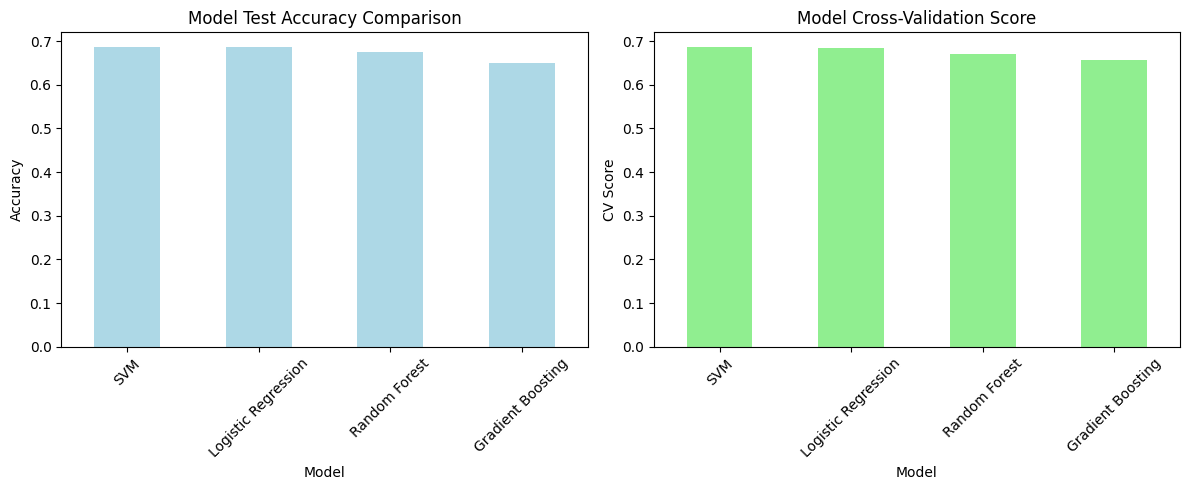

In [13]:
print("\nSTEP 6: MODEL COMPARISON AND SELECTION")
print("=" * 50)

# Create comparison DataFrame
comparison_data = []
for name, result in results.items():
    comparison_data.append({
        'Model': name,
        'Test Accuracy': result['accuracy'],
        'CV Mean': result['cv_mean'],
        'CV Std': result['cv_std']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('CV Mean', ascending=False)

print("MODEL PERFORMANCE COMPARISON:")
print(comparison_df.round(3))

# Select best model based on cross-validation score (more reliable than single test)
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_scaled_data = results[best_model_name]['scaled_data']

print(f"\nBEST MODEL: SVM")
print(f"Cross-validation score: {results[best_model_name]['cv_mean']:.3f}")

# Visualize model comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
comparison_df.set_index('Model')['Test Accuracy'].plot(kind='bar', color='lightblue')
plt.title('Model Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
comparison_df.set_index('Model')['CV Mean'].plot(kind='bar', color='lightgreen')
plt.title('Model Cross-Validation Score')
plt.ylabel('CV Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



STEP 7: DETAILED MODEL EVALUATION
DETAILED CLASSIFICATION REPORT:
                  precision    recall  f1-score   support

Real Madrid Wins       0.69      0.99      0.81       133
            Draw       1.00      0.03      0.05        40
     Kairat Wins       0.00      0.00      0.00        21

        accuracy                           0.69       194
       macro avg       0.56      0.34      0.29       194
    weighted avg       0.68      0.69      0.57       194


CONFUSION MATRIX:
[[132   0   1]
 [ 39   1   0]
 [ 21   0   0]]


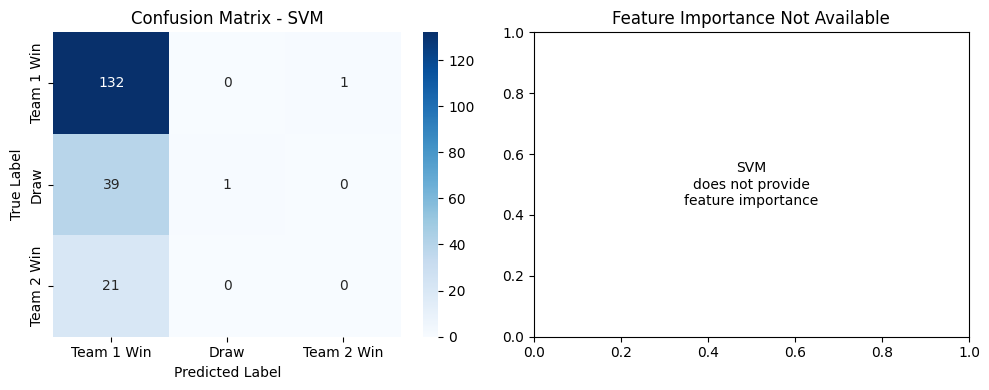

In [14]:
print("\nSTEP 7: DETAILED MODEL EVALUATION")
print("=" * 50)

# Use best model's predictions
best_predictions = results[best_model_name]['predictions']
best_probabilities = results[best_model_name]['probabilities']

# Classification report
print("DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, best_predictions,
                          target_names=['Real Madrid Wins', 'Draw', 'Kairat Wins']))

# Confusion Matrix
print("\nCONFUSION MATRIX:")
cm = confusion_matrix(y_test, best_predictions)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Team 1 Win', 'Draw', 'Team 2 Win'],
            yticklabels=['Team 1 Win', 'Draw', 'Team 2 Win'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Feature importance (if available)
plt.subplot(1, 2, 2)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)

    feature_importance.set_index('feature')['importance'].plot(kind='barh', color='coral')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
else:
    plt.text(0.5, 0.5, f'{best_model_name}\ndoes not provide\nfeature importance',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Feature Importance Not Available')

plt.tight_layout()
plt.show()

In [15]:
print("\nSTEP 8: REAL MADRID vs KAIRAT PREDICTION")
print("=" * 50)

# Create features for Real Madrid vs Kairat matchup
# These values represent a realistic strength difference
real_madrid_vs_kairat_features = {
    # Team strengths (Real Madrid much stronger)
    'strength_difference': 35,  # Large gap
    'home_advantage': 0,  # Neutral venue
    'competition_level': 8,  # Champions League level

    # Goals per game
    'team1_goals_per_game': 2.5,  # Real Madrid
    'team2_goals_per_game': 1.1,  # Kairat

    # Defensive stats
    'team1_goals_against_per_game': 0.8,  # Real Madrid (strong defense)
    'team2_goals_against_per_game': 1.6,  # Kairat (weaker defense)

    # Shot statistics
    'team1_shots_per_game': 18.0,  # Real Madrid
    'team2_shots_per_game': 9.5,   # Kairat
    'team1_shot_accuracy': 48.0,   # Real Madrid
    'team2_shot_accuracy': 32.0,   # Kairat

    # Possession
    'team1_possession': 65.0,  # Real Madrid dominates possession
    'team2_possession': 35.0,  # Kairat
}

# Calculate derived features
real_madrid_vs_kairat_features['goal_difference'] = (
    real_madrid_vs_kairat_features['team1_goals_per_game'] -
    real_madrid_vs_kairat_features['team2_goals_per_game']
)

real_madrid_vs_kairat_features['defensive_difference'] = (
    real_madrid_vs_kairat_features['team2_goals_against_per_game'] -
    real_madrid_vs_kairat_features['team1_goals_against_per_game']
)

real_madrid_vs_kairat_features['team1_efficiency'] = (
    real_madrid_vs_kairat_features['team1_goals_per_game'] /
    real_madrid_vs_kairat_features['team1_shots_per_game']
)

real_madrid_vs_kairat_features['team2_efficiency'] = (
    real_madrid_vs_kairat_features['team2_goals_per_game'] /
    real_madrid_vs_kairat_features['team2_shots_per_game']
)

real_madrid_vs_kairat_features['shot_accuracy_difference'] = (
    real_madrid_vs_kairat_features['team1_shot_accuracy'] -
    real_madrid_vs_kairat_features['team2_shot_accuracy']
)

real_madrid_vs_kairat_features['quality_difference'] = (
    (85 + real_madrid_vs_kairat_features['team1_shot_accuracy'] +
     real_madrid_vs_kairat_features['team1_possession']) / 3 -
    (55 + real_madrid_vs_kairat_features['team2_shot_accuracy'] +
     real_madrid_vs_kairat_features['team2_possession']) / 3
)

# Convert to array format
prediction_features = [real_madrid_vs_kairat_features[col] for col in feature_columns]
prediction_array = np.array([prediction_features])

# Scale if needed
if best_scaled_data:
    prediction_array = scaler.transform(prediction_array)

# Make prediction
prediction = best_model.predict(prediction_array)[0]
probabilities = best_model.predict_proba(prediction_array)[0]



STEP 8: REAL MADRID vs KAIRAT PREDICTION



FINAL PREDICTION RESULTS
Match: Real Madrid vs Kairat Almaty
Model Used: SVM
Model Accuracy: 68.6%
PREDICTED OUTCOME: Real Madrid Wins
CONFIDENCE: 71.2%

DETAILED PROBABILITIES:
------------------------------
Real Madrid Wins: 0.712 (71.2%)
Draw           : 0.187 (18.7%)
Kairat Wins    : 0.102 (10.2%)

KEY FACTORS:
------------------------------
Strength Difference: 35
Goal Difference: 1.4
Quality Difference: 25.3
Shot Accuracy Diff: 16.0%


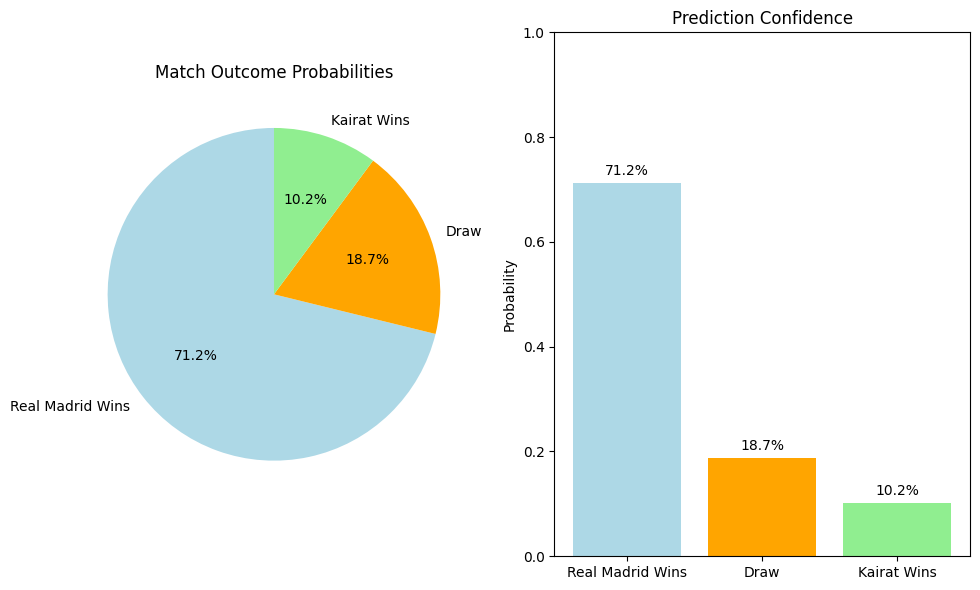

In [17]:
print("\nFINAL PREDICTION RESULTS")
print("=" * 50)
print(f"Match: Real Madrid vs Kairat Almaty")
print(f"Model Used: {best_model_name}")
print(f"Model Accuracy: {results[best_model_name]['cv_mean']:.1%}")
print("=" * 50)

outcomes = ['Real Madrid Wins', 'Draw', 'Kairat Wins']
predicted_outcome = outcomes[prediction]

print(f"PREDICTED OUTCOME: {predicted_outcome}")
print(f"CONFIDENCE: {max(probabilities):.1%}")
print()
print("DETAILED PROBABILITIES:")
print("-" * 30)
for i, (outcome, prob) in enumerate(zip(outcomes, probabilities)):
    print(f"{outcome:15}: {prob:.3f} ({prob*100:.1f}%)")

print()
print("KEY FACTORS:")
print("-" * 30)
print(f"Strength Difference: {real_madrid_vs_kairat_features['strength_difference']}")
print(f"Goal Difference: {real_madrid_vs_kairat_features['goal_difference']:.1f}")
print(f"Quality Difference: {real_madrid_vs_kairat_features['quality_difference']:.1f}")
print(f"Shot Accuracy Diff: {real_madrid_vs_kairat_features['shot_accuracy_difference']:.1f}%")

# Create final visualization
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.pie(probabilities, labels=outcomes, autopct='%1.1f%%', startangle=90,
        colors=['lightblue', 'orange', 'lightgreen'])
plt.title('Match Outcome Probabilities')

plt.subplot(1, 2, 2)
plt.bar(outcomes, probabilities, color=['lightblue', 'orange', 'lightgreen'])
plt.title('Prediction Confidence')
plt.ylabel('Probability')
plt.ylim(0, 1)
for i, prob in enumerate(probabilities):
    plt.text(i, prob + 0.01, f'{prob:.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()